In [22]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
#os.chdir(os.path.join('..', 'notebook_format'))



In [23]:
os.chdir(path)
import numpy as np
import pandas as pd

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn

Author: Ethen

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.26.0

numpy  : 1.20.3
pandas : 1.3.2
sklearn: 0.24.2



# Chi-Square Feature Selection

Seleksi fitur adalah proses dimana secara automatis memilih fitur tersebut pada data anda yang berpengaruh terhadap variabel prediksi atau ouput yang diharapakan. Keuntungan melakukan seleksi fitur sebelum melakukan pemodelan data anda adalah:
1. Menghindari overfitting: Data yang lebih sedikit memberikan peningkatan kinerja pada model dan sediti menghasilkan  sedikit peluang untuk membuat keputusan salah
2. Mengurangi waktu pelatihan. Data yang lebih sedikit berarti algoritma pelatihan semakin cepat




In [135]:
# misal kita memiliki data text berikut
X = np.array(['makan nasi soto', 'nasi soto panas', 'warung nasi soto', 'saya makan nasi pecel'])
y = [1, 1, 2, 0]

# kita akan merubah teks tersebut menjadi matrik dokumen-term,
# dan kita  mencetak output yang mudah dibaca
vect = CountVectorizer()
X_dtm = vect.fit_transform(X)
X_dtm = X_dtm.toarray()
X_dtm
datane=pd.DataFrame(X_dtm, columns = vect.get_feature_names())
X_dtm.shape


(4, 7)

Jika kita menambahkan dengan kelas dari masing masing dokumen diperoleh data seperti berikut

|      | makan| nasi | panas| pecel| saya   | soto    |warung| Kelas |
| ---- | ---- | ---- | ---- | ---- | ------ | ------- | ---- | ----- |
| 0    | 1    | 1    | 0    | 0    | 0      | 1       | 0    | 1     |
| 1    | 0    | 1    | 1    | 0    | 0      | 1       | 0    | 1     |
| 2    | 0    | 1    | 0    | 0    | 0      | 1       | 1    | 2     |
| 3    | 1    | 1    | 0    | 1    | 1      | 0       | 0    | 0     |





Salah satu metode seleksi fitur yang bias digunakan pada data teks adalah seleksi fitur Chi-Square.Uji $\chi^2$ digunakan pada statistik untuk menguji independensi dari dua kejadian (variabel) Khususnya dalam seleksi fitur, metode tersebut digunakan untuk menguji apakah suatu term tertentu yang ada dan kelas tertentu yang ada adalah saling bebas.Secara umum dari dokumen $D$ yang tersedia, kita hitung nilai-nilai berikut untuk setiap term dan merangking tersebut sesuai dengan skor masing-masing

$$
\chi^2(D, t, c) = \sum_{e_t \in \{0, 1\}} \sum_{e_c \in \{0, 1\}} 
\frac{ ( N_{e_te_c} - E_{e_te_c} )^2 }{ E_{e_te_c} }$$

dimana

- $N$ adalah  frekwensi pengamatan dan $E$ adalah frekwensi harapan
- $e_t$ akan bernilai 1 jika dokumen berisi  term $t$ dan 0 jika sebaliknya
- $e_c$ akan bernilai 1 jika dokumen dalam kelas $c$ dan  0 jika sebaliknya

Untuk setiap feature (term), jika memilki score $\chi^2$ tinggi maka menunjukkan  hipotesa null  $H_0$ (independence) 

## Implementasi

Kita pertama menghitung jumlah pengamatan pada masing-masing kelas. Dalam hal dilakukan dengan membuat tabel contingency dari input $X$ (nilai nilai feature ) dan $y$ (label kelas). Setiap masukan $i$, $j$ menyatakan fitur $i$ dan kelas  $j$, dan menghitung jumlah nilai fitur ke $i$ dari semua sample yang menjadi anggota kelas $j$.

Perhatikan bahwa walaupun nilai fitur disini dinyatakan sebagai frekwensi, metode ini juga bekerja dengan baik ketika nilainya adalah nilai tf-idf, karena nilai tf-idf juga merupakan bobot/skala dari frekwensi

In [54]:
# binarisasi kolom output ,
# disini menghitung nilai pengamatan dengan perkalian titik

y_binarized = LabelBinarizer().fit_transform(y)
print(y_binarized)
print()

# baris menunjukkan jumlah pengamatan setiap kelas
# dan kolom menunjukkan setiap fitur
observed = np.dot(y_binarized.T, X_dtm)
print(observed)

[[0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]]

[[1 1 0 1 1 0 0]
 [1 2 1 0 0 2 0]
 [0 1 0 0 0 1 1]]


misalkan. beris kedua dari rangkaian pengamatan diatas menujukkan total jumlah dari term-term yang menjadi kelas 1. Kemudian kita menghitung frekwensi harapan dari setiap term pada masing masing kelas

In [113]:
# menghitung probabilitas setiap kelas dan jumlah fitur; 
# simpan keduanya sebagai array dua dimensi dengan menggunakan reshape
class_prob = y_binarized.mean(axis = 0).reshape(1, -1)
feature_count = X_dtm.sum(axis = 0).reshape(1, -1)
expected = np.dot(class_prob.T, feature_count)

print(expected)

[[0.5  1.   0.25 0.25 0.25 0.75 0.25]
 [1.   2.   0.5  0.5  0.5  1.5  0.5 ]
 [0.5  1.   0.25 0.25 0.25 0.75 0.25]]


In [114]:
class_prob

array([[0.25, 0.5 , 0.25]])

In [115]:
feature_count

array([[2, 4, 1, 1, 1, 3, 1]], dtype=int64)

In [128]:
chisq = (observed - expected) ** 2 / expected
chisq_score = chisq.sum(axis = 0)
print(chisq_score)

[1. 0. 1. 3. 3. 1. 3.]


Kita dapat membutktikan hasil kita dengan library scikit-learn menggunakan fungsi  `chi2`. Kode berikut menghitung nilai chi-square value untuk masing masing fitur. Dari sekumpulan nilai yang dihasilkan element pertama adalah skor chi-square , samakin baik sekor jika semakin besar nilainya dan elemen kedua adalah nilai p, nilai ini semakin baki jika semakin kecil.

In [184]:
chi2score = chi2(X_dtm, y)
chi2score[0]
chi2score[1]
skorchi = np. reshape(chi2score[0], (1, 7))
phisccore=np. reshape(chi2score[1], (1, 7))


In [185]:
chi2score[1]

array([0.60653066, 1.        , 0.60653066, 0.22313016, 0.22313016,
       0.60653066, 0.22313016])

In [187]:
datascore=pd.DataFrame(skorchi, columns = vect.get_feature_names())
dataphi=pd.DataFrame(phisccore, columns = vect.get_feature_names())

In [188]:
datascore

,makan,nasi,panas,pecel,saya,soto,warung
0,1.0,0.0,1.0,3.0,3.0,1.0,3.0


In [190]:
akhirskore = pd.concat([datascore, dataphi])
akhirskore

,makan,nasi,panas,pecel,saya,soto,warung
0,1.000000,0.0,1.000000,3.00000,3.00000,1.000000,3.00000
0,0.606531,1.0,0.606531,0.22313,0.22313,0.606531,0.22313


Scikit-learn menyediakan kelas `SelectKBest` yang dapat digunakan dengan beberapa uji statistik lain. ini akan meranking fitur sesuai dengan uji statistik yang ditentukan dan memilih k teratas( artinya term-term ini dianggap lebih relevan)

In [192]:
kbest = SelectKBest(score_func = chi2, k = 3)
X_dtm_kbest = kbest.fit_transform(datane, y)
mask = kbest.get_support()
X_dtm_kbest = datane.columns[mask]
X_dtm_kbest

Index(['pecel', 'saya', 'warung'], dtype='object')

In [191]:
X_dtm_kbest

Index(['pecel', 'saya', 'soto', 'warung'], dtype='object')

# Kasus berita

In [193]:
from sklearn.datasets import fetch_20newsgroups
 # newsgroups categories
categories = ['alt.atheism','talk.religion.misc',
              'comp.graphics','sci.space']

posts = fetch_20newsgroups(subset='train', categories=categories,
                           shuffle=True, random_state=42,
                           remove=('headers','footers','quotes'))

In [194]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True,stop_words='english')
X = vectorizer.fit_transform(posts.data)

In [195]:
from sklearn.feature_selection import chi2
# menghitung chi2 untuk setiap fitur
chi2score = chi2(X,posts.target)[0]

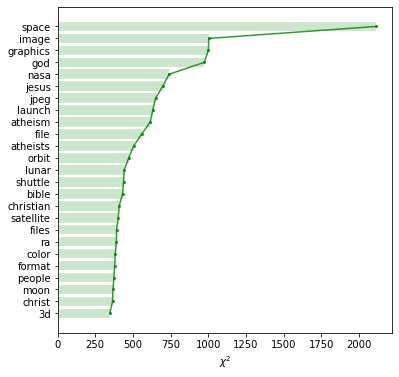

In [196]:
from pylab import barh,plot,yticks,show,grid,xlabel,figure
figure(figsize=(6,6))
wscores = list(zip(vectorizer.get_feature_names(),chi2score))
wchi2 = sorted(wscores,key=lambda x:x[1]) 
topchi2 = list(zip(*wchi2[-25:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
barh(x,topchi2[1],align='center',alpha=.2,color='g')
plot(topchi2[1],x,'-o',markersize=2,alpha=.8,color='g')
yticks(x,labels)
xlabel('$\chi^2$')
show()

In [197]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFpr, chi2, SelectKBest, SelectFwe, f_classif, SelectFdr
import matplotlib.pyplot as plt
%matplotlib inline  
# https://www.kaggle.com/uciml/breast-cancer-wisconsin-data?select=data.csv
df = pd.read_csv("data.csv")
# replace M with 1 and B with 0
my_map = {
          'M':1,
          'B' :0
         }
df['diagnosis'] = df['diagnosis'].map(my_map)
# remove the id column
df.drop(['id'], axis=1, inplace=True)
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [36]:
X = df.drop(['diagnosis'], axis=1)
y = df.diagnosis

In [37]:
X

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [19]:
selector = SelectKBest(score_func=chi2, k=7)
new_data = selector.fit_transform(X, y)
mask = selector.get_support()
new_features = X.columns[mask]
new_features



Index(['radius_mean', 'perimeter_mean', 'area_mean', 'area_se', 'radius_worst',
       'perimeter_worst', 'area_worst'],
      dtype='object')